## Предобработка данных

In [1]:
# Подключение к Google drive

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import pandas as pd

In [3]:
# Загрузим набор данных

df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/freMPL-R.csv', low_memory=False)
df = df.loc[df.Dataset.isin([5, 6, 7, 8, 9])]
df.drop('Dataset', axis=1, inplace=True)
df.dropna(axis=1, how='all', inplace=True)
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115155 entries, 0 to 115154
Data columns (total 20 columns):
Exposure             115155 non-null float64
LicAge               115155 non-null int64
RecordBeg            115155 non-null object
RecordEnd            59455 non-null object
Gender               115155 non-null object
MariStat             115155 non-null object
SocioCateg           115155 non-null object
VehUsage             115155 non-null object
DrivAge              115155 non-null int64
HasKmLimit           115155 non-null int64
BonusMalus           115155 non-null int64
ClaimAmount          115155 non-null float64
ClaimInd             115155 non-null int64
ClaimNbResp          115155 non-null float64
ClaimNbNonResp       115155 non-null float64
ClaimNbParking       115155 non-null float64
ClaimNbFireTheft     115155 non-null float64
ClaimNbWindscreen    115155 non-null float64
OutUseNb             115155 non-null float64
RiskArea             115155 non-null float64
dtypes

В первом уроке мы заметили отрицательную величину убытка для некоторых наблюдений. Заметим, что для всех таких полисов переменная "ClaimInd" принимает только значение 0. Поэтому заменим все соответствующие значения "ClaimAmount" нулями.

In [4]:
NegClaimAmount = df.loc[df.ClaimAmount < 0, ['ClaimAmount','ClaimInd']]
print('Unique values of ClaimInd:', NegClaimAmount.ClaimInd.unique())
NegClaimAmount.head()

Unique values of ClaimInd: [0]


ClaimAmount  ClaimInd
82    -74.206042         0
175 -1222.585196         0
177  -316.288822         0
363  -666.758610         0
375 -1201.600604         0

In [0]:
df.loc[df.ClaimAmount < 0, 'ClaimAmount'] = 0

Перекодируем переменные типа `object` с помощью числовых значений

In [0]:
def SeriesFactorizer(series):
    series, unique = pd.factorize(series)
    reference = {x: i for x, i in enumerate(unique)}
    print(reference)
    return series, reference

In [7]:
df.Gender, GenderRef = SeriesFactorizer(df.Gender)

{0: 'Male', 1: 'Female'}


In [8]:
df.MariStat, MariStatRef = SeriesFactorizer(df.MariStat)

{0: 'Other', 1: 'Alone'}


Для переменных, содержащих более 2 значений, различия между которыми не могут упорядочены, используем фиктивные переменные (one-hot encoding).

In [9]:
list(df.VehUsage.unique())

['Professional', 'Private+trip to office', 'Private', 'Professional run']

In [10]:
VU_dummies = pd.get_dummies(df.VehUsage, prefix='VehUsg', drop_first=False)
VU_dummies.head()

VehUsg_Private  ...  VehUsg_Professional run
0               0  ...                        0
1               0  ...                        0
2               0  ...                        0
3               0  ...                        0
4               1  ...                        0

[5 rows x 4 columns]

Фактор "SocioCateg" содержит информацию о социальной категории в виде кодов классификации CSP. Агрегируем имеющиеся коды до 1 знака, а затем закодируем их с помощью one-hot encoding.

[Wiki](https://fr.wikipedia.org/wiki/Professions_et_cat%C3%A9gories_socioprofessionnelles_en_France#Cr%C3%A9ation_de_la_nomenclature_des_PCS)

[Более подробный классификатор](https://www.ast74.fr/upload/administratif/liste-des-codes-csp-copie.pdf)

In [0]:
df['SocioCateg'] = df.SocioCateg.str.slice(0,4)

In [12]:
pd.DataFrame(df.SocioCateg.value_counts().sort_values()).rename({'SocioCateg': 'Frequency'}, axis=1)

Frequency
CSP7         14
CSP3       1210
CSP1       2740
CSP2       3254
CSP4       7648
CSP6      24833
CSP5      75456

In [0]:
df = pd.get_dummies(df, columns=['VehUsage','SocioCateg'])

Теперь, когда большинство переменных типа `object` обработаны, исключим их из набора данных за ненадобностью.

In [0]:
df = df.select_dtypes(exclude=['object'])

Также создадим такую переменную, как квадрат возраста.

In [15]:
df['DrivAgeSq'] = df.DrivAge.apply(lambda x: x**2)
df.head()

Exposure  LicAge  Gender  ...  SocioCateg_CSP6  SocioCateg_CSP7  DrivAgeSq
0     0.083     332       0  ...                0                0       2116
1     0.916     333       0  ...                0                0       2116
2     0.550     173       0  ...                0                0       1024
3     0.089     364       1  ...                0                0       2704
4     0.233     426       0  ...                1                0       3249

[5 rows x 28 columns]

Для моделирования частоты убытков сгенерируем показатель как сумму индикатора того, что убыток произошел ("ClaimInd") и количества заявленных убытков по различным видам ущерба за 4 предшествующих года ("ClaimNbResp", "ClaimNbNonResp", "ClaimNbParking", "ClaimNbFireTheft", "ClaimNbWindscreen").

В случаях, если соответствующая величина убытка равняется нулю, сгенерированную частоту также обнулим.

In [0]:
df['ClaimsCount'] = df.ClaimInd + df.ClaimNbResp + df.ClaimNbNonResp + df.ClaimNbParking + df.ClaimNbFireTheft + df.ClaimNbWindscreen
df.loc[df.ClaimAmount == 0, 'ClaimsCount'] = 0
df.drop(["ClaimNbResp", "ClaimNbNonResp", "ClaimNbParking", "ClaimNbFireTheft", "ClaimNbWindscreen"], axis=1, inplace=True)

In [17]:
pd.DataFrame(df.ClaimsCount.value_counts()).rename({'ClaimsCount': 'Policies'}, axis=1)

Policies
0.0     104286
2.0       3529
1.0       3339
3.0       2310
4.0       1101
5.0        428
6.0        127
7.0         26
8.0          6
9.0          2
11.0         1

In [18]:
import plotly.express as px
fig = px.scatter(df, x='ClaimsCount', y='ClaimAmount', title='Зависимость между частотой и величиной убытков')
fig.show()

Для моделирования среднего убытка можем рассчитать его как отношение величины убытков к их частоте.

In [0]:
dfAC = df[df.ClaimsCount > 0].copy()
dfAC['AvgClaim'] = dfAC.ClaimAmount/dfAC.ClaimsCount

## Разделение набора данных на обучающую, валидационную и тестовую выборки

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
# Разбиение датасета для частоты на train/val/test

x_train_c, x_test_c, y_train_c, y_test_c = train_test_split(df.drop(['ClaimInd', 'ClaimAmount', 'ClaimsCount'], axis=1), df.ClaimsCount, test_size=0.3, random_state=1)
x_valid_c, x_test_c, y_valid_c, y_test_c = train_test_split(x_test_c, y_test_c, test_size=0.5, random_state=1)

In [0]:
# Разбиение датасета для среднего убытка на train/val/test 

x_train_ac, x_test_ac, y_train_ac, y_test_ac = train_test_split(dfAC.drop(['ClaimInd', 'ClaimAmount', 'ClaimsCount', 'AvgClaim'], axis=1), dfAC.AvgClaim, test_size=0.3, random_state=1)
x_valid_ac, x_test_ac, y_valid_ac, y_test_ac = train_test_split(x_test_ac, y_test_ac, test_size=0.5, random_state=1)

## Градиентный бустинг (Gradient Boosting Machines)

Градиентный бустинг - ансамблевый метод машинного обучения, использующийся для задач классификации, регрессии и ранжирования. Ансамбль представляет собой композицию простых базовых алгоритмов, в качестве которых обычно используются деревья решений. 

Классический алгоритм GBM был предложен [Джеромом Фридманом в
1999 году](https://statweb.stanford.edu/~jhf/ftp/trebst.pdf). Популярность методов GBM пришла в 2015-2016 гг. благодаря большому
успеху библиотеки XGBoost в соревнованиях Kaggle.

Популярные библиотеки для GBM:
* XGBoost (eXtreme Gradient Boosting)
    * скорость, масштабируемость, поддержка распределенных вычислений
    * добавление компоненты регуляризации, отсутствовавшей в классическом алгоритме GBM
* LightGBM
    * использование алгоритмов, основанных на гистограммах, которые позволяют сократить время исполнения и потребление памяти в процессе обучения моделей. 
* CatBoost (Categorical Boosting)
    * предназначается для эффективной работы с категориальными признаками

Все перечисленные библиотеки зачастую имеют сравнимый результат.

### Теория (XGBoost)

**Модель**

Пусть $y_i$ – значение переменной, которое необходимо предсказать, $x_i$ – входные данные.

Модель имеет вид
$$\hat{y}_i = \sum_{k=1}^K f_k(x_i),\hspace{10pt} f_k \in \mathcal{F},$$
где $K$ – количество деревьев, $f$ – функция на пространстве $\mathcal{F}$, которое содержит все возможные деревья решений.

**Целевая функция**
$$\text{Obj}(\theta) = L(\theta) + \Omega(\theta),$$
где 
* $\theta$ – параметры модели;
* $L$ – величина потерь на обучающей выборке  (насколько хорошо модель описывает данные?);
* $\Omega$ – компонента, отвечающая за регуляризацию (насколько модель сложная?).

Тогда для представленной модели $\theta = \{f_1,f_2,\cdots,f_K\}$,

$$\text{Obj} = \sum_{i=1}^n l(y_i, \hat{y}_i) + \sum_{k=1}^K\Omega(f_k),$$
где $l(y_i, \hat{y}_i)$ – функция потерь.

**Обучение**

Необходимо обучить функции $f_i$, каждая из которых включает структуру дерева и значения листьев.

Обозначим $\hat{y}_i^{(t)}$ предсказанное значение на шаге $t$. Тогда целевая функция имеет вид:
$$\text{Obj} = \sum_{i=1}^n l\left(y_i, \hat{y}_i^{(t)}\right) + \sum_{i=1}^t\Omega(f_i).$$

Обучение деревьев происходит поочередно, начиная с постоянного предсказания:
$$\begin{split}\hat{y}_i^{(0)} &= 0\\
\hat{y}_i^{(1)} &= f_1(x_i) = \hat{y}_i^{(0)} + f_1(x_i)\\
\hat{y}_i^{(2)} &= f_1(x_i) + f_2(x_i)= \hat{y}_i^{(1)} + f_2(x_i)\\
&\dots\\
\hat{y}_i^{(t)} &= \sum_{k=1}^t f_k(x_i)= \hat{y}_i^{(t-1)} + f_t(x_i)\end{split}$$

На каждом шаге выбирается дерево, которое оптимизирует целевую функцию.
$$\begin{split}\text{Obj}^{(t)} & = \sum_{i=1}^n l\left(y_i, \hat{y}_i^{(t)}\right) + \sum_{i=1}^t\Omega(f_i) \\
          & = \sum_{i=1}^n l\left(y_i, \hat{y}_i^{(t-1)} + f_t(x_i)\right) + \Omega(f_t) + \mathrm{constant}\end{split}$$


Для упрощения задачи оптимизации для заданной функции потерь используется разложение Тейлора:
$$F(x+\Delta x) \simeq F(x) + F'(x)\Delta x + \frac{1}{2} F''(x)\Delta x^2 + \dots$$

Тогда обозначив градиент и гессиан функции потерь соответственно
$$g_i = \partial_{\hat{y}_i^{(t-1)}} l(y_i, \hat{y}_i^{(t-1)}),\hspace{10pt}h_i = \partial_{\hat{y}_i^{(t-1)}}^2 l(y_i, \hat{y}_i^{(t-1)}),$$
целевая функция будет иметь вид
$$\text{Obj}^{(t)} = \sum_{i=1}^n [l(y_i, \hat{y}_i^{(t-1)}) + g_i f_t(x_i) + \frac{1}{2} h_i f_t^2(x_i)] + \Omega(f_t) + \mathrm{constant}.$$

Убирая константы на шаге $t$, целевая функция упрощается в виде:
$$\text{Obj}^{(t)} = \sum_{i=1}^n [g_i f_t(x_i) + \frac{1}{2} h_i f_t^2(x_i)] + \Omega(f_t).$$

Таким образом, величина потерь $L$ зависит только от $g_i$ и $h_i$.

Благодаря этому, XGBoost поддерживает пользовательские целевые функции, для которых достаточно задать градиент и гессиан функции потерь.

**Регуляризация**

Для начала определим дерево $f_t(x)$:
$$f_t(x) = w_{q(x)}, w \in R^T, q:R^d\rightarrow \{1,2,\cdots,T\},$$
где $w$ – вектор значений на листьях дерева, $T$ – количество листьев, $q$ – функция, которая каждой точке набора данных ставит в соответствие лист дерева.

Тогда сложность модели имеет вид
$$\Omega(f) = \gamma T + \frac{1}{2}\lambda \sum_{j=1}^T w_j^2+ \alpha \sum_{j=1}^T |w_j|,$$
где $\gamma$ – штраф на сложность деревьев, $\lambda$ – сила регуляризации $\ell_2$, $\alpha$ – сила регуляризации $\ell_1$.

**Переобучение**
Для контроля переобучения помимо параметров $\gamma$, $\alpha$ и $\lambda$ используются также параметры:
* Контролирующие сложность модели напрямую 
    * максимальная глубина дерева (`max_depth`)
    * минимальный вес в узле, ниже которого прекращается дальнейшее разделение в этом узле (`min_child_weight`)
* Добавляющие случайность, повышая устойчивость к зашумлению
    * $\eta$ – величина шага. $\eta \in (0,1]$.
    Вместо $\hat{y}_i^{(t)} = \hat{y}_i^{(t-1)} + f_t(x_i)$ используется 
    $\hat{y}_i^{(t)} = \hat{y}_i^{(t-1)} + \eta\cdot f_t(x_i)$
    * Доля подвыборки наблюдений для построения деревьев (`subsample`)
    * Доля подвыборки признаков для построения деревьев (`colsample_bytree`)

Теория, стоящая за оценкой весов на листьях и нахождением разделений выходит за рамки нашего рассмотрения.

* [Chen, Tianqi, and Carlos Guestrin. "Xgboost: A scalable tree boosting system." ](https://arxiv.org/pdf/1603.02754.pdf)
* [XGBoost Documentation](https://xgboost.readthedocs.io/en/latest/tutorials/model.html)
* [А. Дьяконов «Введение в анализ данных и машинное обучение». Градиентный бустинг](https://alexanderdyakonov.files.wordpress.com/2017/06/book_boosting_pdf.pdf)
* [Rokach, Lior. Ensemble Learning: Pattern Classification Using Ensemble Methods (Second Edition)](https://books.google.ru/books/about/Ensemble_Learning_Pattern_Classification.html?id=_AmMDwAAQBAJ&redir_esc=y)

### Выбор гиперпараметров

Стратегии подбора гиперпараметров:
* Поиск на сетке (Grid Search, Randomized Search)
* Покоординатный спуск (Coordinate Descent)
* Генетические алгоритмы (Genetic Algorithms)
* Байесовская оптимизация
* ...

[Использование некоторых алгоритмов подбора гиперпараметров для  XGBoost](https://towardsdatascience.com/doing-xgboost-hyper-parameter-tuning-the-smart-way-part-1-of-2-f6d255a45dde)

Для подбора параметров воспользуемся реализацией Tree-structured Parzen Estimator (TPE) в библиотеке `Hyperopt`. Данный метод использует подход последовательной оптимизации, основанной на модели (sequential model-based optimization, SMBO).

Методы SMBO последовательно строят модели, аппроксимирующие результат гиперпараметров, исходя из предыдущих измерений, и затем делают выбор новых гиперпараметров для проверки модели.

Подход TPE моделирует вероятности $P(x|y)$ и $P(y)$, где $x$ – гиперпараметры, а $y$ – соответствующий им показатель качества. Вероятность $P(x|y)$ моделируется путем замены распределений априорной вероятности с помощью непараметрических оценок плотности.

* [Bergstra, James S., et al. "Algorithms for hyper-parameter optimization." Advances in neural information processing systems. 2011.](https://papers.nips.cc/paper/4443-algorithms-for-hyper-parameter-optimization.pdf)

In [0]:
import xgboost as xgb
from hyperopt import hp, tpe, space_eval
from hyperopt.fmin import fmin

### Построение модели градиентного бустинга для частоты страховых случаев

In [25]:
# Конвертация наборов данных в формат, поддерживающийся XGBoost

train_c = xgb.DMatrix(x_train_c.drop(['Exposure'], axis=1), (y_train_c+1))
valid_c = xgb.DMatrix(x_valid_c.drop(['Exposure'], axis=1), (y_valid_c+1))
test_c = xgb.DMatrix(x_test_c.drop(['Exposure'], axis=1), (y_test_c+1))

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



In [0]:
# Зададим функцию Deviance для распределения Пуассона

def xgb_eval_dev_poisson(yhat, dtrain):
    y = dtrain.get_label()
    return 'dev_poisson', 2 * np.sum( y*np.log(y/yhat) - (y-yhat) )

In [0]:
# Определим функцию для оптимизации гиперпараметров алгоритмом TPE

def objective(params):
    parameters = {
        'objective': 'count:poisson',
        'max_depth':  int(params['max_depth']),
        'min_child_weight': params['min_child_weight'],
        'subsample': params['subsample'],
        'colsample_bytree': params['colsample_bytree'],
        'eta': params['eta'],
        'alpha': params['alpha'],
        'lambda': params['lambda'],        
    }
    
    cv_result = xgb.cv(parameters, train_c, num_boost_round=int(params['num_boost_round']), nfold=5, seed=0, maximize=False, feval=xgb_eval_dev_poisson, early_stopping_rounds=10)
    score = cv_result['test-dev_poisson-mean'][-1:].values[0]
    return score

In [0]:
# Определим границы, в которых будем искать гиперпараметры 

space = {'num_boost_round': hp.quniform('num_boost_round', 50, 500, 1),
         'max_depth': hp.choice('max_depth', [5, 8, 10, 12, 15]),
         'min_child_weight': hp.uniform('min_child_weight', 0, 50),
         'subsample': hp.uniform('subsample', 0.5, 1),
         'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
         'alpha': hp.uniform('alpha', 0, 1),
         'lambda': hp.uniform('lambda', 0, 1),
         'eta': hp.uniform('eta', 0.01, 1),
        }

In [29]:
# Оптимизация (количество итераций снижено для ускорения работы)

best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50)

100%|██████████| 50/50 [28:19<00:00, 28.65s/it, best loss: 4866.3272461999995]


In [30]:
# Оптимальные гиперпараметры 

best_params = space_eval(space, best)
best_params['objective'] = 'count:poisson'
best_params

{'alpha': 0.1989061159900046,
 'colsample_bytree': 0.6141844436962857,
 'eta': 0.019395209161837734,
 'lambda': 0.2394432371216211,
 'max_depth': 5,
 'min_child_weight': 14.18265823439159,
 'num_boost_round': 492.0,
 'objective': 'count:poisson',
 'subsample': 0.5145424426783405}

In [0]:
# Построение модели с ранней остановкой (early stopping)

progress = dict()
xgb_freq = xgb.train(num_boost_round=int(best_params.pop('num_boost_round')), params=best_params, dtrain=train_c, feval=xgb_eval_dev_poisson, maximize=False, evals=[(train_c, "train"),(valid_c, "valid")], early_stopping_rounds=10, evals_result=progress, verbose_eval=False)

In [0]:
# Построение модели без ранней остановки

best_params = space_eval(space, best)
best_params['objective'] = 'count:poisson'
progress_wo_es = dict()
xgb_freq_wo_es = xgb.train(num_boost_round=int(best_params.pop('num_boost_round')), params=best_params, dtrain=train_c, feval=xgb_eval_dev_poisson, maximize=False, evals=[(train_c, "train"),(valid_c, "valid"), (test_c, "test")], evals_result=progress_wo_es, verbose_eval=False)

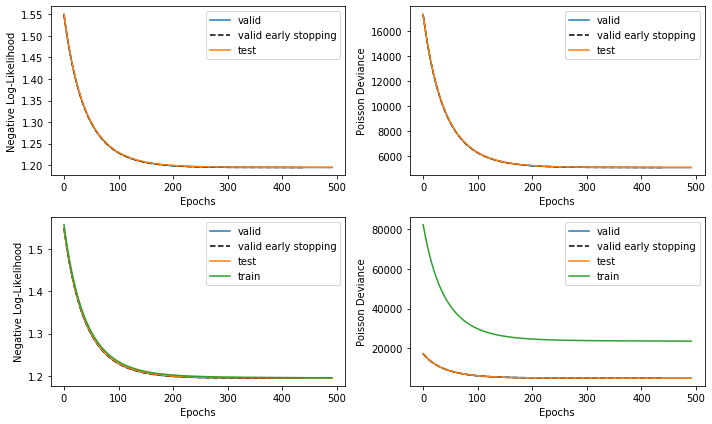

In [33]:
import matplotlib.pyplot as plt
plt.subplots(2,2, figsize=(10,6))
plt.subplot(2,2,1)
plt.plot(progress_wo_es['valid']['poisson-nloglik'], label='valid')
plt.plot(progress['valid']['poisson-nloglik'], label='valid early stopping', linestyle='dashed', color='black')
plt.plot(progress_wo_es['test']['poisson-nloglik'], label='test')
plt.xlabel('Epochs'); plt.ylabel('Negative Log-Likelihood'); plt.legend(); plt.tight_layout()
plt.subplot(2,2,2)
plt.plot(progress_wo_es['valid']['dev_poisson'], label='valid')
plt.plot(progress['valid']['dev_poisson'], label='valid early stopping', linestyle='dashed', color='black')
plt.plot(progress_wo_es['test']['dev_poisson'], label='test')
plt.xlabel('Epochs'); plt.ylabel('Poisson Deviance'); plt.legend(); plt.tight_layout()
plt.subplot(2,2,3)
plt.plot(progress_wo_es['valid']['poisson-nloglik'], label='valid')
plt.plot(progress['valid']['poisson-nloglik'], label='valid early stopping', linestyle='dashed', color='black')
plt.plot(progress_wo_es['test']['poisson-nloglik'], label='test')
plt.plot(progress_wo_es['train']['poisson-nloglik'], label='train')
plt.xlabel('Epochs'); plt.ylabel('Negative Log-Likelihood'); plt.legend(); plt.tight_layout()
plt.subplot(2,2,4)
plt.plot(progress_wo_es['valid']['dev_poisson'], label='valid')
plt.plot(progress['valid']['dev_poisson'], label='valid early stopping', linestyle='dashed', color='black')
plt.plot(progress_wo_es['test']['dev_poisson'], label='test')
plt.plot(progress_wo_es['train']['dev_poisson'], label='train')
plt.xlabel('Epochs'); plt.ylabel('Poisson Deviance'); plt.legend(); plt.tight_layout(); plt.show()

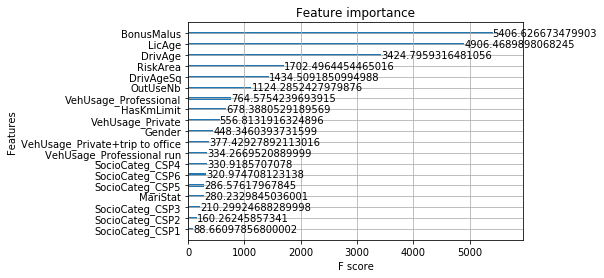

In [34]:
# Отбор признаков (Feature Importance)

importance_type = ['total_gain', 'gain', 'weight', 'total_cover', 'cover']
xgb.plot_importance(xgb_freq, importance_type=importance_type[0]); plt.show()

### Построение модели градиентного бустинга для среднего убытка

In [35]:
# Конвертация наборов данных в формат, поддерживающийся XGBoost

train_ac = xgb.DMatrix(x_train_ac.drop(['Exposure'], axis=1), (y_train_ac))
valid_ac = xgb.DMatrix(x_valid_ac.drop(['Exposure'], axis=1), (y_valid_ac))
test_ac = xgb.DMatrix(x_test_ac.drop(['Exposure'], axis=1), (y_test_ac))

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



In [0]:
# Зададим функцию Deviance для гамма-распределения

def xgb_eval_dev_gamma(yhat, dtrain):
    y = dtrain.get_label()
    return 'dev_gamma', 2 * np.sum(-np.log(y/yhat) + (y-yhat)/yhat)

In [0]:
# Определим функцию для оптимизации гиперпараметров алгоритмом TPE

def objective(params):
    parameters = {
        'objective': 'reg:gamma',
        'max_depth':  int(params['max_depth']),
        'min_child_weight': params['min_child_weight'],
        'subsample': params['subsample'],
        'colsample_bytree': params['colsample_bytree'],
        'eta': params['eta'],
        'alpha': params['alpha'],
        'lambda': params['lambda']
    }
    
    cv_result = xgb.cv(parameters, train_ac, num_boost_round=int(params['num_boost_round']), nfold=5, feval=xgb_eval_dev_gamma, seed=0, maximize=False, early_stopping_rounds=10)
    score = cv_result['test-dev_gamma-mean'][-1:].values[0]
    return score

In [0]:
# Определим границы, в которых будем искать гиперпараметры 

space = {'num_boost_round': hp.quniform('num_boost_round', 50, 500, 1),
         'max_depth': hp.choice('max_depth', [5, 8, 10, 12, 15]),
         'min_child_weight': hp.uniform('min_child_weight', 0, 50),
         'subsample': hp.uniform('subsample', 0.5, 1),
         'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
         'alpha': hp.uniform('alpha', 0, 1),
         'lambda': hp.uniform('lambda', 0, 1),
         'eta': hp.uniform('eta', 0.01, 1)
        }

In [39]:
# Оптимизация (количество итераций снижено для ускорения работы)

best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50)

100%|██████████| 50/50 [02:21<00:00,  2.83s/it, best loss: 3221.8331542000005]


In [40]:
# Оптимальные гиперпараметры 

best_params = space_eval(space, best)
best_params['objective'] = 'reg:gamma'
best_params

{'alpha': 0.41685169232292696,
 'colsample_bytree': 0.588706154090592,
 'eta': 0.2509072720612424,
 'lambda': 0.247530822539404,
 'max_depth': 5,
 'min_child_weight': 16.84011449898538,
 'num_boost_round': 221.0,
 'objective': 'reg:gamma',
 'subsample': 0.5770971058476779}

In [0]:
# Построение модели с ранней остановкой (early stopping)

progress = dict()
xgb_avgclaim = xgb.train(num_boost_round=int(best_params.pop('num_boost_round')), params=best_params, dtrain=train_ac, feval=xgb_eval_dev_gamma, maximize=False, evals=[(train_ac, "train"),(valid_ac, "valid")], early_stopping_rounds=10, evals_result=progress, verbose_eval=False)

In [0]:
# Построение модели без ранней остановки

best_params = space_eval(space, best)
best_params['objective'] = 'reg:gamma'
progress_wo_es = dict()
xgb_avgclaim_wo_es = xgb.train(num_boost_round=int(best_params.pop('num_boost_round')), params=best_params, dtrain=train_ac, feval=xgb_eval_dev_gamma, maximize=False, evals=[(train_ac, "train"),(valid_ac, "valid"), (test_ac, "test")], evals_result=progress_wo_es, verbose_eval=False)

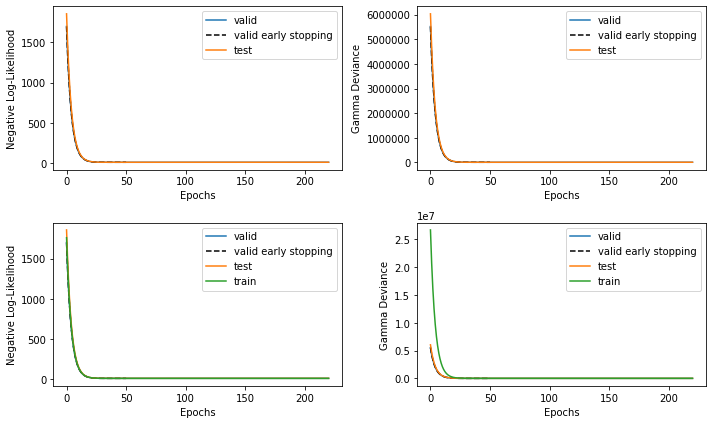

In [43]:
plt.subplots(2,2, figsize=(10,6))
plt.subplot(2,2,1)
plt.plot(progress_wo_es['valid']['gamma-nloglik'], label='valid')
plt.plot(progress['valid']['gamma-nloglik'], label='valid early stopping', linestyle='dashed', color='black')
plt.plot(progress_wo_es['test']['gamma-nloglik'], label='test')
plt.xlabel('Epochs'); plt.ylabel('Negative Log-Likelihood'); plt.legend(); plt.tight_layout()
plt.subplot(2,2,2)
plt.plot(progress_wo_es['valid']['dev_gamma'], label='valid')
plt.plot(progress['valid']['dev_gamma'], label='valid early stopping', linestyle='dashed', color='black')
plt.plot(progress_wo_es['test']['dev_gamma'], label='test')
plt.xlabel('Epochs'); plt.ylabel('Gamma Deviance'); plt.legend(); plt.tight_layout()
plt.subplot(2,2,3)
plt.plot(progress_wo_es['valid']['gamma-nloglik'], label='valid')
plt.plot(progress['valid']['gamma-nloglik'], label='valid early stopping', linestyle='dashed', color='black')
plt.plot(progress_wo_es['test']['gamma-nloglik'], label='test')
plt.plot(progress_wo_es['train']['gamma-nloglik'], label='train')
plt.xlabel('Epochs'); plt.ylabel('Negative Log-Likelihood'); plt.legend(); plt.tight_layout()
plt.subplot(2,2,4)
plt.plot(progress_wo_es['valid']['dev_gamma'], label='valid')
plt.plot(progress['valid']['dev_gamma'], label='valid early stopping', linestyle='dashed', color='black')
plt.plot(progress_wo_es['test']['dev_gamma'], label='test')
plt.plot(progress_wo_es['train']['dev_gamma'], label='train')
plt.xlabel('Epochs'); plt.ylabel('Gamma Deviance'); plt.legend(); plt.tight_layout(); plt.show()

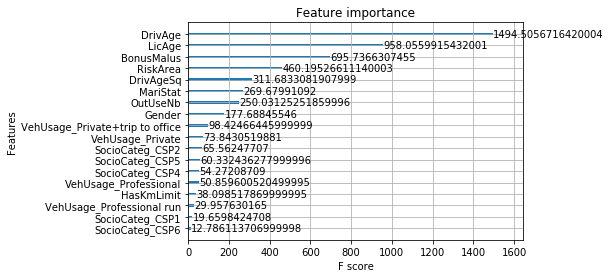

In [44]:
# Отбор признаков (Feature Importance)

importance_type = ['total_gain', 'gain', 'weight', 'total_cover', 'cover']
xgb.plot_importance(xgb_avgclaim, importance_type=importance_type[0]); plt.show()

### Интерпретация моделей градиентного бустинга

* [Lundberg S. M., Erion G. G., Lee S. I. Consistent individualized feature attribution for tree ensembles](https://arxiv.org/abs/1802.03888)
* [SHAP GitHub](https://github.com/slundberg/shap)
* [Explain Your Model with the SHAP Values](https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d)

In [45]:
!pip install shap

     |████████████████████████████████| 266kB 2.9MB/s 
  Created wheel for shap: filename=shap-0.34.0-cp36-cp36m-linux_x86_64.whl size=383175 sha256=e9765be5684933377e90f72db53fab750702c6173cd0a6fbf23fe62573192729
  Stored in directory: /root/.cache/pip/wheels/28/7e/28/57bc9fcb77579b0df6561298648249370648c0b91dfe42c8ec
Successfully built shap


In [0]:
import shap

In [47]:
explainer = shap.TreeExplainer(xgb_avgclaim)
shap_values = explainer.shap_values(x_test_ac.drop(['Exposure'], axis=1))

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [48]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], x_test_ac.drop(['Exposure'], axis=1).iloc[0,:])

In [49]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, x_test_ac.drop(['Exposure'], axis=1))

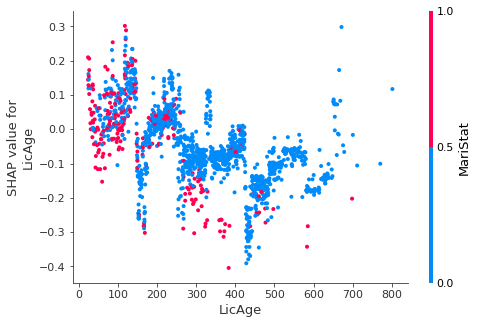

In [50]:
shap.dependence_plot("LicAge", shap_values, x_test_ac.drop(['Exposure'], axis=1))

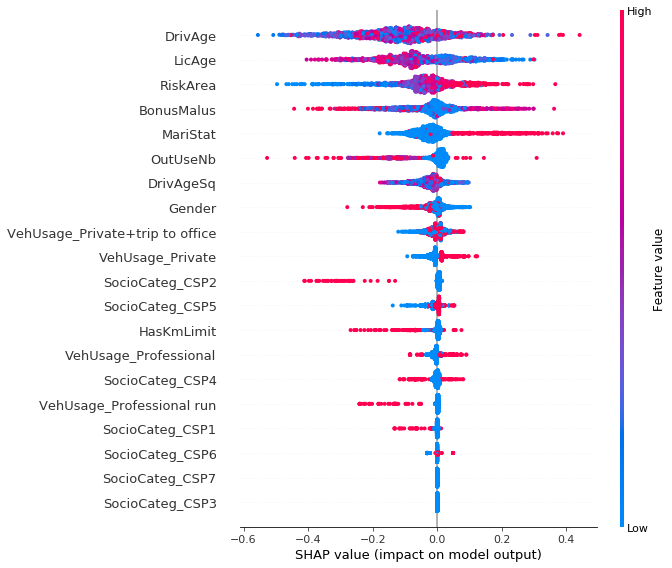

In [51]:
shap.summary_plot(shap_values, x_test_ac.drop(['Exposure'], axis=1))

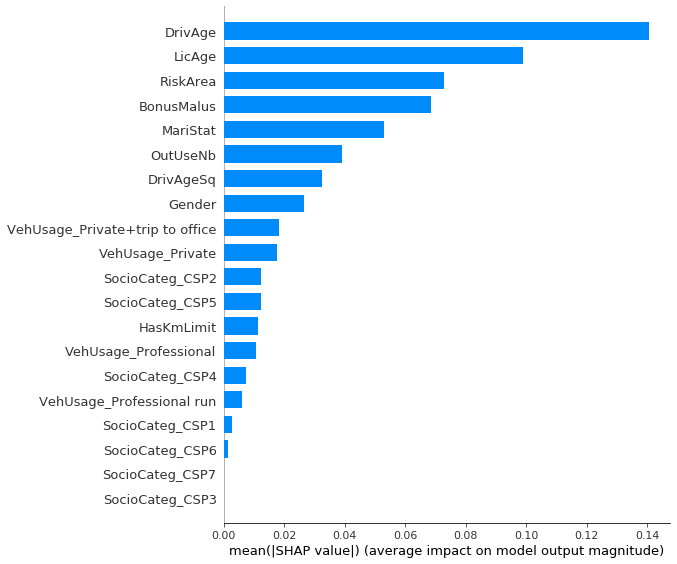

In [52]:
shap.summary_plot(shap_values, x_test_ac.drop(['Exposure'], axis=1), plot_type="bar")

* [ELI5 Documentation](https://eli5.readthedocs.io/en/latest/index.html)
* [Константин Лопухин, ELI5: как понять, что выучила ваша ML модель](https://www.youtube.com/watch?v=pqqcUzj3R90)

In [53]:
!pip install eli5

     |████████████████████████████████| 112kB 2.9MB/s 


In [54]:
import eli5

The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
Using TensorFlow backend.


In [55]:
eli5.show_weights(xgb_avgclaim)

In [56]:
eli5.explain_prediction(xgb_avgclaim, x_test_ac.drop(['Exposure'], axis=1).iloc[0,:])

Explanation(estimator='<xgboost.core.Booster object at 0x7fb75b3e4780>', description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble. Each leaf has an output score, and expected scores can also be\nassigned to parent nodes. Contribution of one feature on the decision path\nis how much expected score changes from parent to child. Weights of all \nfeatures sum to the output score of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does not show how increasing or\n   decreasing the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision paths', is_regression=True, targets=[TargetExplanation(target='y', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='<BIAS>', weight=7.8798012171438545, std=None, value=1.0), FeatureWeight(feature='LicAge', weight=0.12945276677510334, std=None, value=335.0), FeatureWeight(feature='Gender', weight=0.07025775059589855, std=None, value=1.0), FeatureWeight(feature='SocioCateg_CSP5', weight=0.009968900957855457, std=None, value=1.0), FeatureWeight(feature='SocioCateg_CSP4', weight=0.00864961596454202, std=None, value=0.0), FeatureWeight(feature='HasKmLimit', weight=0.0030790077911210523, std=None, value=0.0), FeatureWeight(feature='VehUsage_Professional run', weight=0.0011610240972473873, std=None, value=0.0), FeatureWeight(feature='SocioCateg_CSP2', weight=3.259318612395569e-05, std=None, value=0.0)], neg=[FeatureWeight(feature='DrivAge', weight=-0.2729294936211183, std=None, value=47.0), FeatureWeight(feature='BonusMalus', weight=-0.07760022733683772, std=None, value=50.0), FeatureWeight(feature='MariStat', weight=-0.07241944345055187, std=None, value=0.0), FeatureWeight(feature='RiskArea', weight=-0.05316878353676815, std=None, value=7.0), FeatureWeight(feature='VehUsage_Private+trip to office', weight=-0.023745256281845283, std=None, value=1.0), FeatureWeight(feature='DrivAgeSq', weight=-0.012464086582042696, std=None, value=2209.0), FeatureWeight(feature='OutUseNb', weight=-0.004815993266519171, std=None, value=0.0), FeatureWeight(feature='VehUsage_Private', weight=-0.0022756338300644052, std=None, value=0.0)], pos_remaining=0, neg_remaining=0), proba=None, score=7.582983958605996, weighted_spans=None, heatmap=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None, image=None)

### Использование моделей градиентного бустинга

In [0]:
predictions = pd.DataFrame()
predictions['CountPredicted'] = xgb_freq.predict(xgb.DMatrix(df.drop(['ClaimsCount', 'Exposure', 'ClaimAmount', 'ClaimInd'], axis=1))) - 1
predictions['AvgClaimPredicted'] = xgb_avgclaim.predict(xgb.DMatrix(df.drop(['ClaimsCount', 'Exposure', 'ClaimAmount', 'ClaimInd'], axis=1)))

In [58]:
predictions['CountPredicted'].min()

0.0311814546585083

In [59]:
predictions['BurningCost'] = predictions.CountPredicted * predictions.AvgClaimPredicted
predictions.head()

CountPredicted  AvgClaimPredicted  BurningCost
0        0.258711        1347.039673   348.493805
1        0.258711        1347.039673   348.493805
2        0.204213         670.749146   136.975952
3        0.182026        1023.775940   186.353378
4        0.148344        1111.004150   164.810577

### * Домашнее задание: Многоклассовая классификация

В текущем домашнем задание предлагается построить модель многоклассовой классификации для показателя `RiskVar`. Воспользуемся другими частями датасета freMPL (1 и 2).

In [0]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, precision_score
from hyperopt import hp, tpe, space_eval
from hyperopt.fmin import fmin

def SeriesFactorizer(series):
    series, unique = pd.factorize(series)
    reference = {x: i for x, i in enumerate(unique)}
    print(reference)
    return series, reference

In [0]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/freMPL-R.csv', low_memory=False)

In [0]:
df = df.loc[df.Dataset.isin([1, 2])]
df.drop('Dataset', axis=1, inplace=True)
df.dropna(axis=1, how='all', inplace=True)
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

In [63]:
df.head()

Exposure  LicAge   RecordBeg  ... RiskVar          Garage ClaimInd
0     0.583     366  2004-06-01  ...    15.0            None        0
1     0.200     187  2004-10-19  ...    20.0            None        0
2     0.083     169  2004-07-16  ...    17.0            None        0
3     0.375     170  2004-08-16  ...    17.0  Private garage        0
4     0.500     224  2004-01-01  ...    19.0            None        1

[5 rows x 22 columns]

In [67]:
df.iloc[0]

Exposure              0.583
LicAge                  366
RecordBeg        2004-06-01
RecordEnd               NaN
VehAge                    2
Gender               Female
MariStat              Other
SocioCateg             CSP1
VehUsage       Professional
DrivAge                  55
HasKmLimit                0
BonusMalus               72
VehBody               sedan
VehPrice                 D 
VehEngine         injection
VehEnergy           regular
VehMaxSpeed    160-170 km/h
VehClass                  B
ClaimAmount               0
RiskVar                  15
Garage                 None
ClaimInd                  0
Name: 0, dtype: object

Предобработайте данные

In [71]:
df.Gender, GenderRef = SeriesFactorizer(df.Gender)
df.MariStat, MariStatRef = SeriesFactorizer(df.MariStat)

{0: 'Female', 1: 'Male'}
{0: 'Other', 1: 'Alone'}


In [0]:
df.drop(["RecordBeg", "RecordEnd"], inplace=True, axis=1)

In [0]:
chislennie_colnames = ["Exposure", "LicAge", "Gender", "MariStat", "DrivAge", "HasKmLimit", "BonusMalus", "ClaimAmount", "RiskVar", "ClaimInd"]

In [0]:
categorical_colnames = ["VehAge", "SocioCateg", "VehUsage", "VehBody", "VehPrice", "VehEngine", "VehEnergy", "VehMaxSpeed", "VehClass", "Garage"]

In [75]:
df = pd.get_dummies(data=df, columns=categorical_colnames)
df.head()

Exposure  LicAge  ...  Garage_None  Garage_Private garage
0     0.583     366  ...            1                      0
1     0.200     187  ...            1                      0
2     0.083     169  ...            1                      0
3     0.375     170  ...            0                      1
4     0.500     224  ...            1                      0

[5 rows x 140 columns]

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40732 entries, 0 to 40731
Columns: 140 entries, Exposure to Garage_Private garage
dtypes: float64(3), int64(7), uint8(130)
memory usage: 8.2 MB


In [77]:
df.describe()

Exposure        LicAge  ...   Garage_None  Garage_Private garage
count  40732.000000  40732.000000  ...  40732.000000           40732.000000
mean       0.445484    272.088039  ...      0.729647               0.100216
std        0.284627    162.796180  ...      0.444147               0.300292
min        0.001000      0.000000  ...      0.000000               0.000000
25%        0.195000    139.000000  ...      0.000000               0.000000
50%        0.416000    244.000000  ...      1.000000               0.000000
75%        0.666000    394.000000  ...      1.000000               0.000000
max        1.000000    940.000000  ...      1.000000               1.000000

[8 rows x 140 columns]

XGBoost для многоклассовой классификации принимает на вход значения меток классов в виде `[0, num_classes]`. Поэтому, вычтем из значений переменной `RiskVar` единицу.

In [0]:
df.RiskVar -= 1

Данная переменная принимает значения от 1 до 20, которые, возможно, упорядочены. Посмотрим, сколько полисов соответствуют каждому из значений `RiskVar`, используя метод `groupby`. Для полученных значений также посчитаем нормированную частоту.

In [79]:
FreqCount = pd.DataFrame(df.groupby('RiskVar')["RiskVar"].count().to_frame().rename(columns={"RiskVar": "Count"}) , columns=['Count'])
FreqCount['Freq'] = FreqCount.Count / FreqCount.Count.sum()
FreqCount

Count      Freq
RiskVar                 
0.0        531  0.013036
1.0        451  0.011072
2.0        660  0.016203
3.0        603  0.014804
4.0        979  0.024035
5.0        902  0.022145
6.0       1634  0.040116
7.0       1439  0.035328
8.0       1170  0.028724
9.0       1314  0.032260
10.0      2533  0.062187
11.0      2445  0.060027
12.0      2719  0.066753
13.0      2096  0.051458
14.0      4625  0.113547
15.0      4906  0.120446
16.0      3444  0.084553
17.0      2614  0.064176
18.0      2773  0.068079
19.0      2894  0.071050

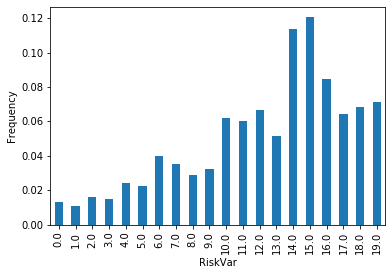

In [80]:
FreqCount.Freq.plot(kind='bar')
plt.ylabel('Frequency')
plt.show()

In [81]:
FreqCount

Count      Freq
RiskVar                 
0.0        531  0.013036
1.0        451  0.011072
2.0        660  0.016203
3.0        603  0.014804
4.0        979  0.024035
5.0        902  0.022145
6.0       1634  0.040116
7.0       1439  0.035328
8.0       1170  0.028724
9.0       1314  0.032260
10.0      2533  0.062187
11.0      2445  0.060027
12.0      2719  0.066753
13.0      2096  0.051458
14.0      4625  0.113547
15.0      4906  0.120446
16.0      3444  0.084553
17.0      2614  0.064176
18.0      2773  0.068079
19.0      2894  0.071050

In [82]:
FreqCount.Freq.sum()

1.0

Заметим, что в данном случае присутствует проблема несбалансированности классов. Поэтому, для того, чтобы по возможности избежать ее, воспользуемся взвешиванием наблюдений для обучения модели. Для этого в исходном наборе данных создадим столбец `weight`. Присвоим ему некоторые значения, например, можно задать `0.5` для значений `RiskVar` 14 и 15, а для остальных - 1 (Для этого можем использовать функцию `np.where` и метод `isin` для `pandas.Series`). Также можно попробовать какой-либо другой способ задания весов, приведенный пример не гарантирует хороших результатов.

In [83]:
df['weight'] = 1
df.loc[df["RiskVar"].isin([14,15]), "weight"] = 0.5
df.weight.value_counts()

1.0    31201
0.5     9531
Name: weight, dtype: int64

Разобьем имеющийся набор данных на обучающую, валидационную и тестовую выборки в отношениях 70%/15%/15% соответственно. Зададим зерно для случайного разбиения равным 10.

In [0]:
train_colnames = df.columns.drop("RiskVar").tolist()

In [0]:
x_train, x_test, y_train, y_test = train_test_split(df[train_colnames], df.RiskVar, test_size=0.3, random_state=10)
x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=10)

Далее, создадим объекты `DMatrix` для обучающей, валидационной и тестовой выборок. Для обучающей выборки также укажем параметр `weight` равным полученному ранее столбцу весов. Данный столбец также нужно исключить из объекта передаваемого в параметр `data`.

In [86]:
xgb_train = xgb.DMatrix(x_train.drop(['weight'], axis=1), (y_train), weight=x_train.weight)
xgb_valid = xgb.DMatrix(x_valid.drop(['weight'], axis=1), (y_valid))
xgb_test = xgb.DMatrix(x_test.drop(['weight'], axis=1), (y_test))

Series.base is deprecated and will be removed in a future version
Series.base is deprecated and will be removed in a future version


Для оптимизации гиперпараметров можно воспользоваться различными методами. Однако, в случае Hyperopt, на процесс подбора гиперпараметров может уйти немалое количество часов.

In [0]:
'<Ваш код здесь>'

Далее обучим нашу модель с оптимальными параметрами

In [0]:
param ={'alpha': 0.8020992938175673,
 'colsample_bytree': 0.7154473206384617,
 'eta': 0.6329518647706083,
 'lambda': 0.5559850361749056,
 'max_depth': 8,
 'min_child_weight': 0.8638760709963555,
 'num_boost_round': 67.0,
 'num_class': 20,
 'subsample': 0.9836932076937734,
'objective': 'multi:softprob'}

In [88]:
param

{'alpha': 0.8020992938175673,
 'colsample_bytree': 0.7154473206384617,
 'eta': 0.6329518647706083,
 'lambda': 0.5559850361749056,
 'max_depth': 8,
 'min_child_weight': 0.8638760709963555,
 'num_boost_round': 67.0,
 'num_class': 20,
 'objective': 'multi:softprob',
 'subsample': 0.9836932076937734}

In [0]:
model = xgb.XGBClassifier(n_estimators=800, **param)

In [90]:
model.get_params

<bound method XGBModel.get_params of XGBClassifier(alpha=0.8020992938175673, base_score=0.5, booster='gbtree',
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.7154473206384617, eta=0.6329518647706083,
              gamma=0, lambda=0.5559850361749056, learning_rate=0.1,
              max_delta_step=0, max_depth=8,
              min_child_weight=0.8638760709963555, missing=None,
              n_estimators=800, n_jobs=1, nthread=None, num_boost_round=67.0,
              num_class=20, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9836932076937734, verbosity=1)>

In [92]:
model.fit(x_train, y_train, early_stopping_rounds=10, eval_metric="mlogloss", eval_set=[(x_valid, y_valid)], verbose=True)

[0]	validation_0-mlogloss:2.90583
Will train until validation_0-mlogloss hasn't improved in 10 rounds.
[1]	validation_0-mlogloss:2.79789
[2]	validation_0-mlogloss:2.72026
[3]	validation_0-mlogloss:2.67428
[4]	validation_0-mlogloss:2.61685
[5]	validation_0-mlogloss:2.5827
[6]	validation_0-mlogloss:2.54718
[7]	validation_0-mlogloss:2.523
[8]	validation_0-mlogloss:2.49572
[9]	validation_0-mlogloss:2.47221
[10]	validation_0-mlogloss:2.44685
[11]	validation_0-mlogloss:2.41947
[12]	validation_0-mlogloss:2.39938
[13]	validation_0-mlogloss:2.37487
[14]	validation_0-mlogloss:2.3537
[15]	validation_0-mlogloss:2.33698
[16]	validation_0-mlogloss:2.3225
[17]	validation_0-mlogloss:2.30371
[18]	validation_0-mlogloss:2.29136
[19]	validation_0-mlogloss:2.28228
[20]	validation_0-mlogloss:2.26654
[21]	validation_0-mlogloss:2.25573
[22]	validation_0-mlogloss:2.24251
[23]	validation_0-mlogloss:2.23206
[24]	validation_0-mlogloss:2.22347
[25]	validation_0-mlogloss:2.21326
[26]	validation_0-mlogloss:2.20653
[

XGBClassifier(alpha=0.8020992938175673, base_score=0.5, booster='gbtree',
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.7154473206384617, eta=0.6329518647706083,
              gamma=0, lambda=0.5559850361749056, learning_rate=0.1,
              max_delta_step=0, max_depth=8,
              min_child_weight=0.8638760709963555, missing=None,
              n_estimators=800, n_jobs=1, nthread=None, num_boost_round=67.0,
              num_class=20, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9836932076937734, verbosity=1)

Посчитаем метрики accuracy и f1 на наших наборах данных, также можем визуализировать confusion matrix, например, с помощью `plt.imshow()`. Можно использовать предложенный ниже код.

In [96]:
dfsets = [{'set': 'train', 'dmat': x_train, 'target': y_train},
          {'set': 'valid', 'dmat': x_valid, 'target': y_valid},
          {'set': 'test', 'dmat': x_test, 'target': y_test}]
for dfset in dfsets:
    class_preds = model.predict(dfset["dmat"])
    print('F1 Score on ' + str(dfset['set'])+':', f1_score(dfset["target"], class_preds, average="micro")) # Посчитаем F1 Score
    print('Precision Score on ' + str(dfset['set'])+':', precision_score(dfset["target"], class_preds, average='macro')) # Посчитаем Precision Score
    print('Accuracy on ' + str(dfset['set'])+':', accuracy_score(dfset["target"], class_preds)) # Посчитаем Accuracy
    print()

F1 Score on train: 0.9967031425364759
Precision Score on train: 0.9975232151271403
Accuracy on train: 0.9967031425364759

F1 Score on valid: 0.47086743044189855
Precision Score on valid: 0.5494054505861181
Accuracy on valid: 0.47086743044189855

F1 Score on test: 0.46923076923076923
Precision Score on test: 0.5330257448293418
Accuracy on test: 0.46923076923076923



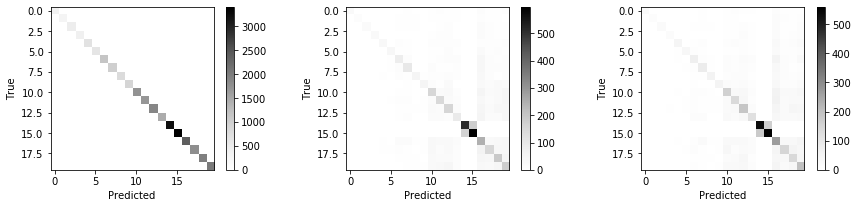

In [97]:
plt.subplots(1,3, figsize=(15,3))
for i in range(len(dfsets)):
    confmatrix = confusion_matrix(dfsets[i]['target'], model.predict(dfsets[i]['dmat']))
    plt.subplot(1,3,i+1)
    plt.imshow(confmatrix, cmap='Greys')
    plt.colorbar()
    plt.ylabel('True')
    plt.xlabel('Predicted')
plt.show()

Как вы оцениваете качество построенной модели? Какие проблемы могут здесь присутствовать? Как можно улучшить результат?

Качество низкое, произошло переобучение. Необходимо изменить подход к количеству параметров. 